# 1. High-level interface

The `h5rdmtoolbox` wraps additional features around the `h5py` package such that the core functionalities are untouched and syntax is mostly the same.

In [1]:
import h5rdmtoolbox as h5tbx

h5tbx.__version__

'1.3.0a2'

## 1.1 File creation

Note: A filename must not be given! It is generated temporarily in the users local tmp directory. Great for testing and playing around:

In [2]:
with h5tbx.File() as h5:
    h5.create_dataset(name='my_dataset', data=4.3)

In addition to `filename`, `hdf_filename` is provided as a `pathlib` object, which can also be accessed if the file is closed.

In [3]:
h5.hdf_filename

WindowsPath('C:/Users/Matthias/AppData/Local/h5rdmtoolbox/h5rdmtoolbox/tmp/tmp_0/tmp0.hdf')

## 1.2 Group and dataset creation
Attributes can be passed alongside with the creation methods:

In [4]:
with h5tbx.File(attrs={'comment': 'this is my favorite file'}) as h5:
    h5.create_group('measurement_data', attrs={'comment': 'measurement data of my experiment'})
    h5.create_dataset(name='my_dataset', data=4.3, attrs=dict(units='m/s'))

In [5]:
with h5tbx.File() as h5:
    h5.attrs['a dict'] = {'a': 4.5}
    a = h5.attrs['a dict']
a

{'a': 4.5}

## 1.3 Dumping file content

"Dumping" the content to the screen helps quickly get an idea of the file and its structure:

In [6]:
with h5tbx.File(attrs={'comment': 'this is my favorite file'}) as h5:
    h5.create_group('measurement_data', attrs={'comment': 'measurement data of my experiment'})
    h5.create_dataset(name='my_dataset', data=[3, 4, 5], attrs=dict(units='m/s', long_name='my dataset'))

    h5.dump()

## 1.4 Special dataset creation from various sources

The advantage of allowing attributes to be passed during group and dataset creation is that we can write a data reader.

There various special methods implemented, such as:
- `create_dataset_from_csv`
- `create_datasets_from_csv`
- `create_dataset_from_image`
- `create_dataset_from_xarray_dataset`
- `create_from_dict`
- `create_from_yaml`
- `create_from_jsonld`

The file `data.yaml` has a specific content, which can be interpreted by the toolbox: 

In [7]:
with h5tbx.File() as h5:
    h5.create_from_yaml('data.yaml')
    h5.dump(False)

## 1.5 Natural naming

If natural naming is enabled and datasets/groups have no spaces, they can be addressed like this:

In [8]:
with h5tbx.File(h5.hdf_filename) as h5:
    vel = h5['grp'].subgrp.velocity
    print(vel)

<HDF5 dataset "velocity": shape (2,), type "<f8", convention "h5py">


Note, that this behaviour can be switched off:

In [9]:
with h5tbx.set_config(natural_naming=False):
    with h5tbx.File(h5.hdf_filename) as h5:
        try:
            vel = h5.grp.subgrp.velocity
        except AttributeError as e:
            print(e)

'File' object has no attribute 'grp'


# 2. Data exchange through xarray

A more "natural" way of exchanging data between HDF5 and users is by `xarray` rather than `numpy` as dimensions (coordinates) and attributes can be passed, too:

In [10]:
import numpy as np

In [11]:
with h5tbx.File() as h5:
    h5.create_dataset('y', np.linspace(0, 42, 34),
                      attrs={'units': 'm'},
                      make_scale=True)
    h5.create_dataset('x', np.linspace(-50, 100, 119),
                      attrs={'units': 'm'},
                      make_scale=True)
    h5.create_dataset('time', np.linspace(0, 1, 10), make_scale=True,
                     attrs={'units': 'min', 'long_name': 'Time since start'})
    h5.create_dataset(name='u',
                      data=np.random.random((10, 34, 119)),
                      attrs={'units': 'm/s'},
                      attach_scale=('time', 'y', 'x'))

In [12]:
hdf_filename_1 = h5.hdf_filename

## 2.1 Retrieving xarray data

In [13]:
with h5tbx.File(hdf_filename_1) as h5:
    u = h5.u[..., 0]
u

<xarray.DataArray 'u' (time: 10, y: 34)>
0.5423 0.583 0.5911 0.2642 0.08292 ... 0.4058 0.7105 0.1392 0.1489 0.07348
Coordinates:
  * time     (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * y        (y) float64 0.0 1.273 2.545 3.818 5.091 ... 38.18 39.45 40.73 42.0
    x        float64 -50.0
Attributes:
    units:    m/s

## 2.2 Retrieving numpy data
It is still possible to return numpy array data by calling property `.values`

In [14]:
with h5tbx.File(hdf_filename_1) as h5:
    u_np = h5.u.values[()]
u_np

array([[[0.54229126, 0.06444542, 0.9610757 , ..., 0.16064656,
         0.89255949, 0.42293364],
        [0.58300852, 0.57734277, 0.38370748, ..., 0.98063868,
         0.58047734, 0.38746127],
        [0.59110744, 0.07428377, 0.98081361, ..., 0.77955667,
         0.55599888, 0.98706934],
        ...,
        [0.65684541, 0.2134795 , 0.07394899, ..., 0.35552055,
         0.83618793, 0.17252277],
        [0.9115462 , 0.43426303, 0.26359537, ..., 0.63429802,
         0.93812039, 0.39696188],
        [0.08744626, 0.90482062, 0.71159926, ..., 0.55981838,
         0.20300623, 0.69322232]],

       [[0.10559108, 0.36843246, 0.00625761, ..., 0.08755626,
         0.40815655, 0.42407377],
        [0.63845152, 0.52685852, 0.65683871, ..., 0.66661557,
         0.60927105, 0.64075803],
        [0.59615863, 0.56144408, 0.94674623, ..., 0.46215068,
         0.20796098, 0.78648823],
        ...,
        [0.9854912 , 0.76861616, 0.13010627, ..., 0.99542324,
         0.89693674, 0.74720971],
        [0.2

### 2.3 Assigning xarray data

**Wise versa**, datasets can be created from `xarray` objects, too:

In [15]:
with h5tbx.File() as h5:
    h5.create_dataset('u_loaded', data=u)
    h5.dump(False)

hdf_filename_2 = h5.hdf_filename

### 2.4 Other implications by interfacing with `xarray`

#### 2.4.1 Plotting

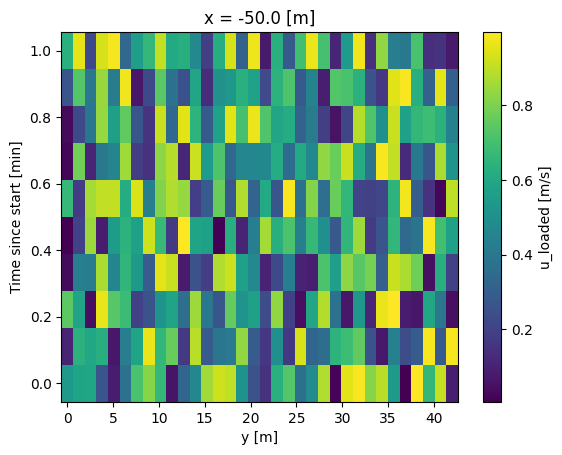

In [16]:
u[()].plot()

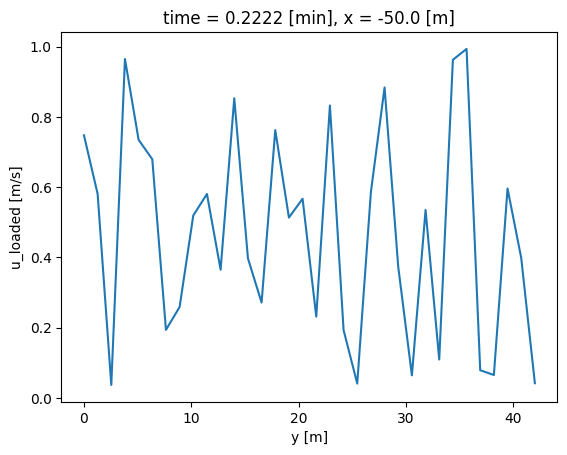

In [17]:
u[2, :].plot()

#### 2.4.2 Indexing and selecting data

See `xarray`'s documentation for in-depth explanations (https://docs.xarray.dev/en/latest/user-guide/indexing.html).

"Xarray offers extremely flexible indexing routines that combine the best features of NumPy and pandas for data selection."

In [18]:
u.coords

Coordinates:
  * time     (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * y        (y) float64 0.0 1.273 2.545 3.818 5.091 ... 38.18 39.45 40.73 42.0
    x        float64 -50.0

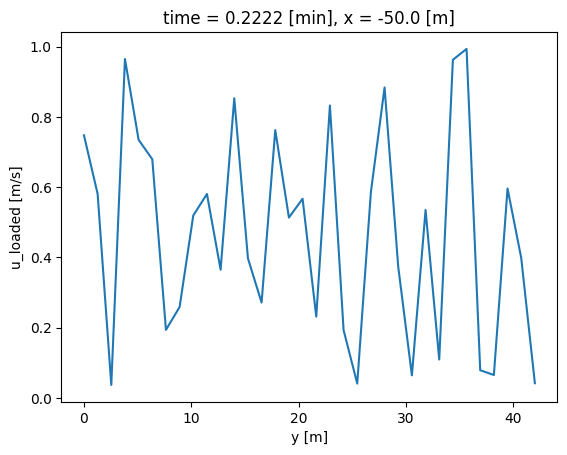

In [19]:
u.isel(time=2).plot()

The toolbox offers the mechanism at file level, too:

In [20]:
with h5tbx.File(hdf_filename_2) as h5:
    u03_isel = h5.u_loaded.isel(time=0, y=3)
u03_isel

<xarray.DataArray 'u_loaded' ()>
0.2642
Coordinates:
    time     float64 0.0
    y        float64 3.818
    x        float64 -50.0
Attributes:
    units:    m/s

In [21]:
with h5tbx.File(hdf_filename_2) as h5:
    u03_sel = h5.u_loaded.sel(time=0, y=3, method='nearest')
u03_sel

<xarray.DataArray 'u_loaded' ()>
0.5911
Coordinates:
    time     float64 0.0
    y        float64 2.545
    x        float64 -50.0
Attributes:
    units:    m/s

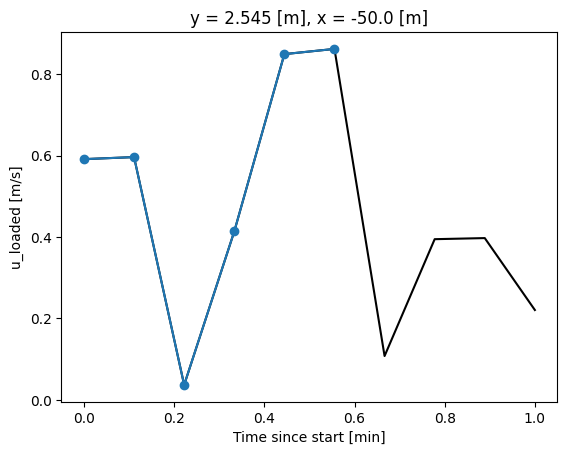

In [22]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_full = h5.u_loaded.sel(y=3, method='nearest')
    u_sub_nearest = h5.u_loaded.sel(time=np.arange(0.05, 0.53, 0.02), y=3, method='nearest')
u_full.plot(color='k')
u_sub_nearest.plot(marker='o')

In [23]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_sub = h5['u_loaded'].isel(y=h5['u_loaded'].y>20.3, time=h5['u_loaded'].time<0.5)
    u_full = h5['u_loaded'][()]

In [24]:
u_full.y.data[0]

0.0

In [25]:
u_sub.y.data[0]

20.363636363636363

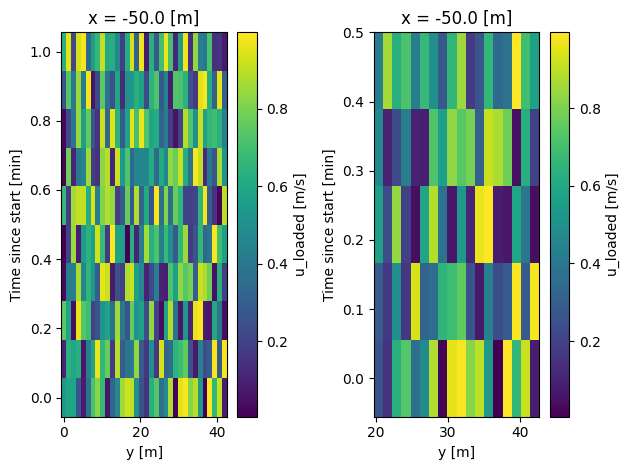

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, tight_layout=True)
u_full.plot(ax=axs[0])
u_sub.plot(ax=axs[1])

# 3. Extensions:

Extensions implement additional interfaces. Find out more here: https://h5rdmtoolbox.readthedocs.io/en/latest/userguide/misc/Extensions.html

## 3.1 Working with units

In [27]:
from h5rdmtoolbox.extensions import units

In [28]:
with h5tbx.File() as h5:
    h5.create_dataset(name='vel',
                      data=np.random.random((3, 100, 50)),
                      attrs=dict(units='m/s'))
    v = h5.vel.to_units('cm/s')[0, :, :]

In [29]:
v

<xarray.DataArray 'vel' (dim_0: 100, dim_1: 50)>
61.1 45.17 3.066 24.24 8.703 88.61 69.28 ... 2.067 91.5 85.79 44.63 83.7 99.56
Dimensions without coordinates: dim_0, dim_1
Attributes:
    units:    cm/s

## 3.2 vectors

In [30]:
from h5rdmtoolbox.extensions import vector

In [31]:
with h5tbx.File('vortex_pair.hdf') as h5:
    vec = h5.Vector(uu='u', vv='v')[0,::4,::4]

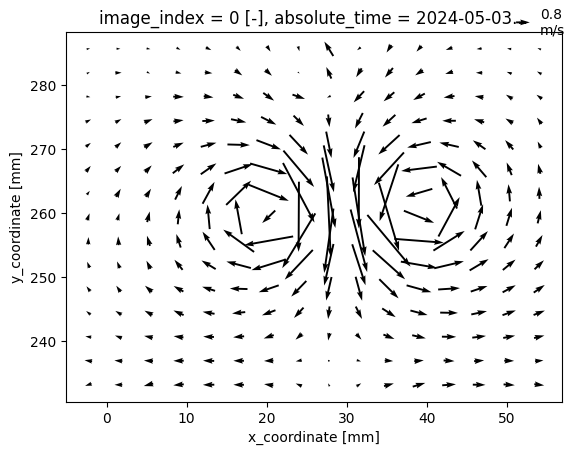

In [32]:
vec.plot.quiver(x='x', y='y', u='uu', v='vv')

In [33]:
with h5tbx.File('vortex_pair.hdf') as h5:
    vec = h5.Vector(uu='u', vv='v').sel(relative_time=3.4, method='nearest')

In [34]:
#vec

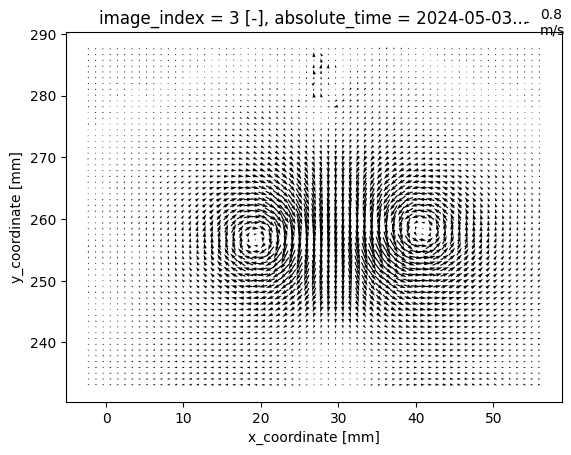

In [35]:
vec.plot.quiver(x='x', y='y', u='uu', v='vv')